In [1]:
# importing libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import math
from statsmodels.stats.diagnostic import het_goldfeldquandt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
# importing dataset
df = pd.read_csv("../data/processed/df_model.csv")

In [3]:
df.head(3)

,month,day,heat_deg_days_c,total_snow_cm,spd_of_max_gust_kmPerhr,day_of_week,sum_checkpointCount
0,1.0,1.0,23.3,1.8,63.0,Thursday,1782.098415
1,1.0,2.0,26.8,0.0,50.0,Friday,1584.821232
2,1.0,3.0,31.1,17.0,41.0,Saturday,1818.754038


## One-Hot Encoding - day_of_week variable

In [4]:
df = pd.get_dummies(df, columns=['day_of_week'], prefix='day')

**Dropping day_Monday variable after one hot encoding. This is done so as to not introduce multicollinearity to our model.**
- chose to drop day_Monday as it was the least correlated with our dependent variable

In [5]:
df = df.drop('day_Monday', axis=1)

# Multiple Linear Regression
- statsmodels package is used as it is optimized for insights as opposed to scikit-learn's linear regression class as it is optimized for prediction.

### 1. Multiple linear Regression Model - Building a baseline model with all variables.

In [6]:
target_variable = 'sum_checkpointCount'
predictor_variables = [ 'month', 'day', 'heat_deg_days_c', 'total_snow_cm', 'spd_of_max_gust_kmPerhr', 'day_Friday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday']

X = df[predictor_variables]
X = sm.add_constant(X)
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     sum_checkpointCount   R-squared:                       0.795
Model:                             OLS   Adj. R-squared:                  0.786
Method:                  Least Squares   F-statistic:                     96.68
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):           9.92e-88
Time:                         18:42:53   Log-Likelihood:                -3144.2
No. Observations:                  287   AIC:                             6312.
Df Residuals:                      275   BIC:                             6356.
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

**Few Observations:**
1. **R-squared and adj r-squared values are close** to each other which is good and doesn't really penalize much for the inclusion of more variables. We'll also keep a close eye on BIC(6312) which imposes more stronger penalty for inclusion of variables that doesn't contribute in prediction
2. p-values of several independent variables are more than 0.05(default significance level). a higher p-value(>0.05) indicates that the corresponding independent variable is not statistically significant and does not contribute to explaining the variation in the dependent variable. So, below variables could be removed for the next iteration in model building.
    - month
    - day
    - total_snow_cm
    - day_Friday
    - day_Tuesday
3. Condition Number is low which states that the model is not suffering from multicollinearity issues.
4. Durbin-Watson value being close to 2 indicates that there are no autocorrelation issues which is pretty abundant in time series data.

### 2. Multiple Linear Regression model - after removing certain variables that don't crontribute to prediction

In [7]:
target_variable = 'sum_checkpointCount'
predictor_variables = ['heat_deg_days_c', 'spd_of_max_gust_kmPerhr',
       'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Wednesday']

X = df[predictor_variables]
X = sm.add_constant(X)
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     sum_checkpointCount   R-squared:                       0.793
Model:                             OLS   Adj. R-squared:                  0.788
Method:                  Least Squares   F-statistic:                     178.3
Date:                 Thu, 19 Oct 2023   Prob (F-statistic):           1.42e-92
Time:                         18:42:53   Log-Likelihood:                -3145.5
No. Observations:                  287   AIC:                             6305.
Df Residuals:                      280   BIC:                             6331.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

**Few Observations:**
1. out F-statistic now has doubled. F-statistic tells us how significant our overall model is. But AIC didnt seem to reduce after removal of variables.
2. Interpreting coefficients and intercepts
    - y-intercept seems to be about 83000.
    - Every unit change in heat_deg_days_c subtracts 2067 from the intercept. higher the heat_deg_days_c values lower will be the output value. Also the standard of this variable is too low relative to the coefficient value. Built a model just based on this one independent variable, it was able to explain 70% of the variation in the dependent variable.
    - spd_of_max_gust_kmPerhr, day_Saturday, day_Sunday seems to bring down the score as there are negative correlations observed with the response variable.
    - if the day is thursday there our model is going to add 7309 to our output.

# Checking if Assumptions of Linear Regression holds

### 1. Linearity

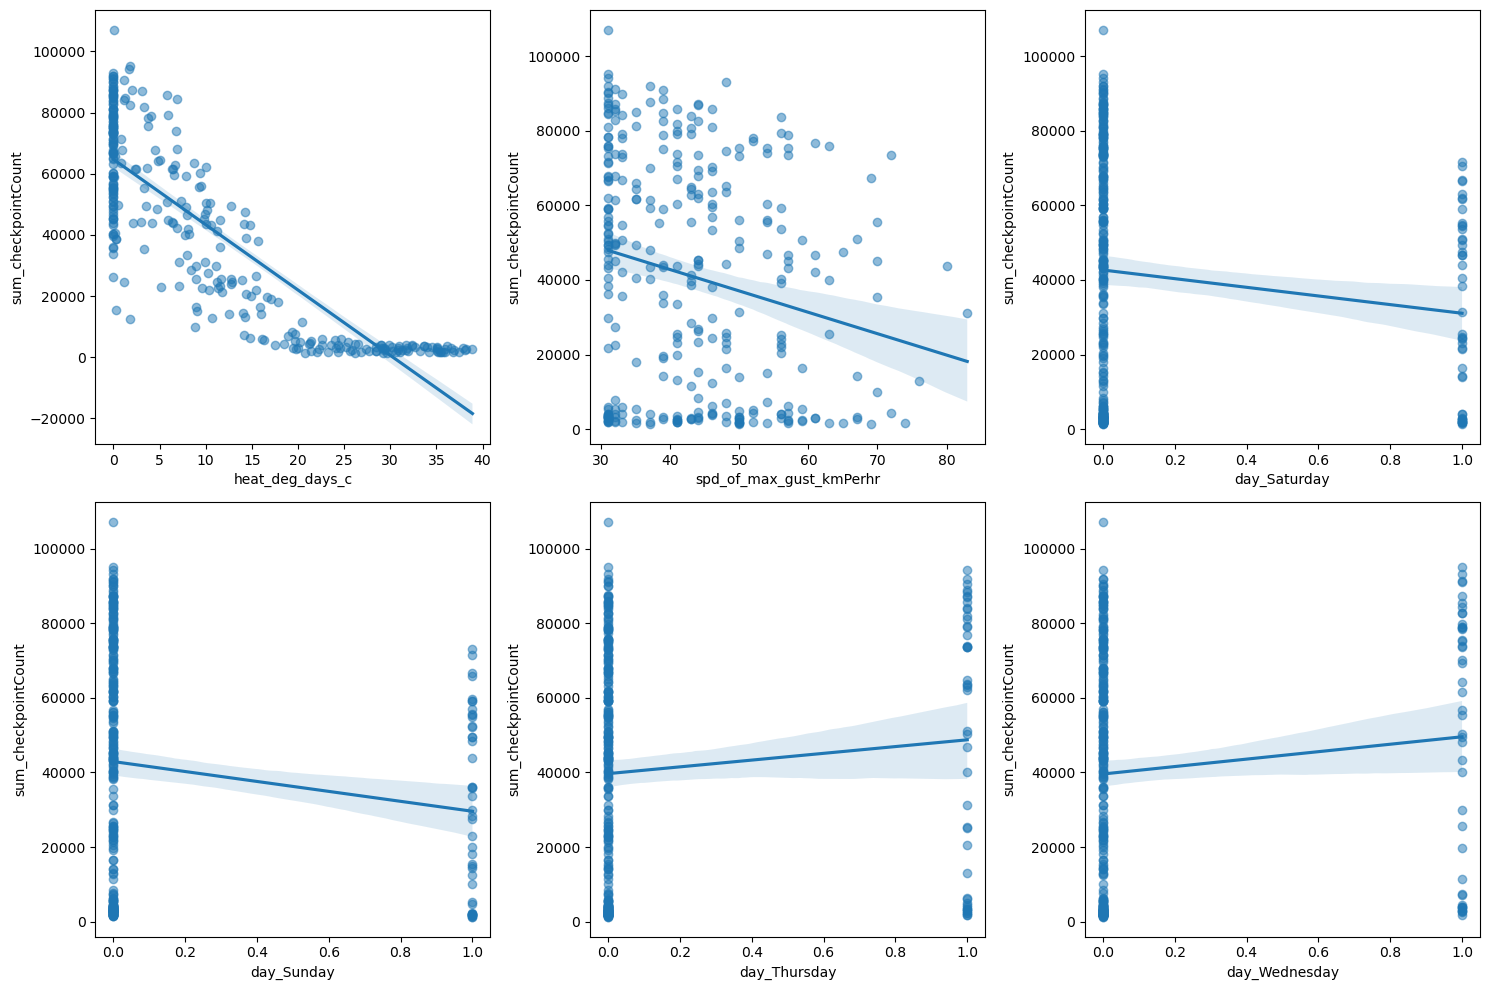

In [8]:
var_to_plot = ['heat_deg_days_c', 'spd_of_max_gust_kmPerhr', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Wednesday']
num_plots = len(var_to_plot)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i, col in enumerate(var_to_plot):
    ax = axes[i // cols, i % cols]  # Get the current axis
    sns.regplot(data=df, x=col, y=target_variable, ax=ax, scatter_kws={'alpha': 0.5})
    ax.set_xlabel(col)
    ax.set_ylabel(target_variable)

for i in range(num_plots, rows * cols):
    fig.delaxes(axes[i // cols, i % cols])

plt.tight_layout()

plt.show()

### 2. Normality

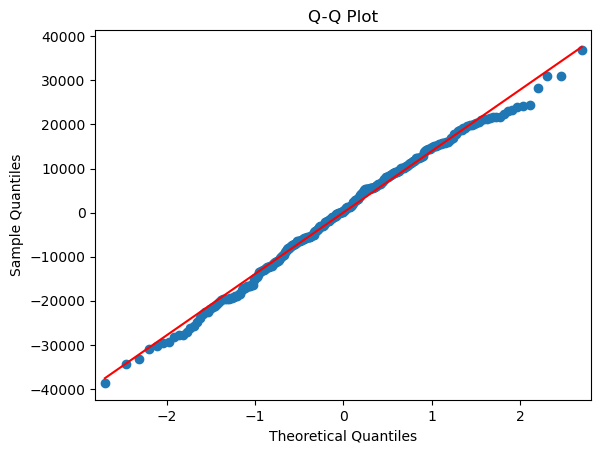

residuals appears to be normally distributed (fail to reject H0)


In [9]:
residuals = model.resid

sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot')
plt.show()

# shapiro-wilk test to test normality
statistic, p_value = shapiro(residuals)

alpha = 0.05
if p_value > alpha:
    print("residuals appears to be normally distributed (fail to reject H0)")
else:
    print("residuals does not appear to be normally distributed (reject H0)")


### 3. Homoscedasticity

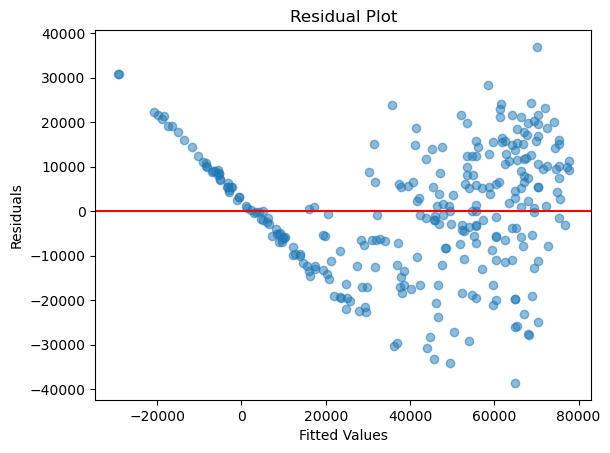

In [10]:
residuals = model.resid
plt.scatter(model.fittedvalues, residuals, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

It appears that homoscedasticity assumption fails and that the errors dont really have constant variance upon visual expection. So, proceeding with statistical test called Goldfeld Quandt test that tells us if there exists patterns in the above residualt plot.

In [11]:
# goldfeld quandt test
gq_test = het_goldfeldquandt(residuals, X_train, alternative='increasing')

if gq_test[1] > 0.05:
    print("No evidence of heteroscedasticity (fail to reject null hypothesis)")
else:
    print("Evidence of heteroscedasticity (reject null hypothesis)")

No evidence of heteroscedasticity (fail to reject null hypothesis)


The tests say otherwise. So, assuming the assumption of homoscedasticity holds.

### 4. Autocorrelation
- Durbin Watson is close to 2 indicating that there are no autocorrelation issues.

### 5. Multicollinearity
- Low Condition number that indicates no multicollinearity issues. If there was a high condition number, it would've been displayed in the Notes section of the statsmodel summary

### 6. Endogeneity
- This is a tough problem to fix if there exists endogeneity. It is caused mostly due to omitted variable bias. But I strongly believe that temp related data that we have is the most important causal variable and proceeding to assume that there is no confounding variable and hence no endogeneity

## All assumptions of Linear Regression holds well.

## Log Transformation of the dependent variable

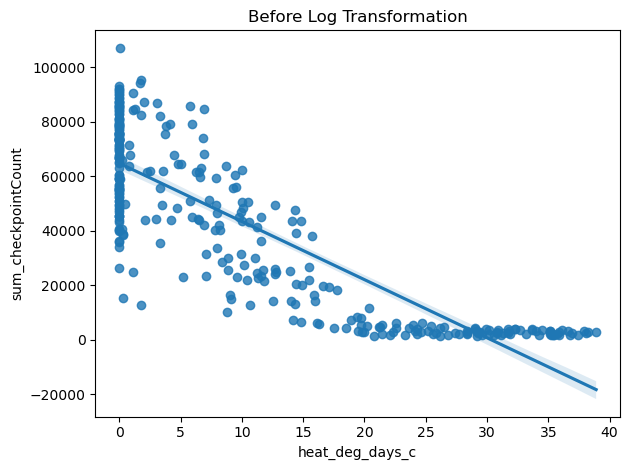

In [12]:
sns.regplot(data=df, x='heat_deg_days_c', y='sum_checkpointCount')
plt.title("Before Log Transformation")
plt.tight_layout()
plt.show()

- From the above plot, I think our model could perform better if we take log of sum_checkpointCount variable. Lets proceed.

In [13]:
# log of sum_checkpointCount
df['log_sum_checkpointCount'] = np.log(df['sum_checkpointCount'])

**reg plot of log(sum_checkpointCount) against heat_deg_days_c**

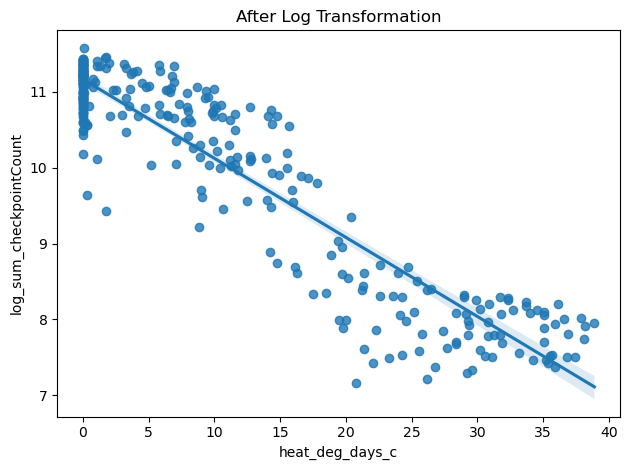

In [14]:
sns.regplot(data=df, x='heat_deg_days_c', y='log_sum_checkpointCount')
plt.title("After Log Transformation")
plt.tight_layout()
plt.show()

**Observation:** - There seems to be a better linear fit between the above two variables after log transformation.

### Now, lets see how has the pearson correlation coefficient changed  before and after log transformation

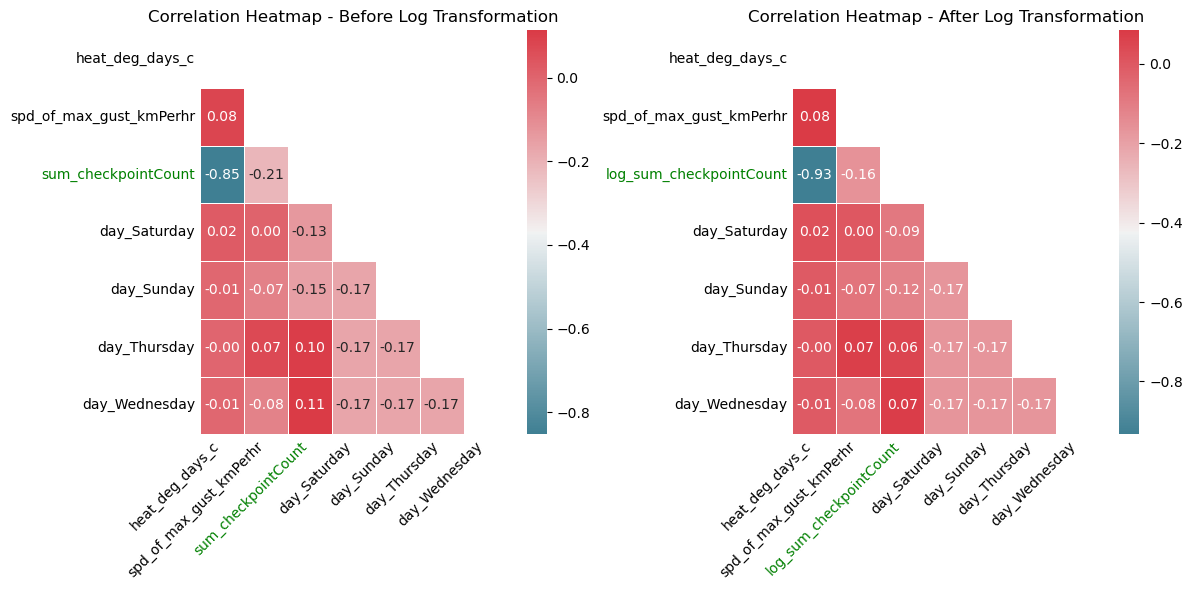

In [15]:
columns_to_include_original = ['heat_deg_days_c', 'spd_of_max_gust_kmPerhr', 'sum_checkpointCount', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Wednesday']
columns_to_include_log = ['heat_deg_days_c', 'spd_of_max_gust_kmPerhr', 'log_sum_checkpointCount', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Wednesday']

df_original = df[columns_to_include_original]
df_log_transformed = df[columns_to_include_log]

corr_matrix_original = df_original.corr()
corr_matrix_log_transformed = df_log_transformed.corr()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

titles = ['Correlation Heatmap - Before Log Transformation', 'Correlation Heatmap - After Log Transformation']

for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    mask = np.triu(np.ones_like(corr_matrix_original, dtype=bool) if i == 0 else np.ones_like(corr_matrix_log_transformed, dtype=bool))
    corr_matrix = corr_matrix_original if i == 0 else corr_matrix_log_transformed
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, ax=ax, annot=True, fmt=".2f", cmap=colormap, mask=mask, linewidths=0.5, cbar=True)
    sum_checkpointCount_index = columns_to_include_original.index('sum_checkpointCount') if i == 0 else columns_to_include_log.index('log_sum_checkpointCount')
    ax.get_xticklabels()[sum_checkpointCount_index].set_color('green')
    ax.get_yticklabels()[sum_checkpointCount_index].set_color('green')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)

plt.tight_layout()
plt.show()

**Observations:**
1. Our dependent variable is now **more strongly correlated** to heat_deg_days_c (From -0.85 to -0.93) after the log transformation.
2. It looks like our one hot encoded day variables took a hit with correlation after transformation. But I'd trade having a good increase of correlation in our most important variable compared to other variables that have high standard errors in their coefficients and doesnt contribute as much when building the model, any day.
3. lets proceed building the linear regression model with log transformed dependent variable and see how the coefficients of independent variables changed.

### 3. Multiple Linear Regression model - after log transformation of the dependent variable

In [16]:
target_variable = 'log_sum_checkpointCount'
predictor_variables = ['heat_deg_days_c', 'spd_of_max_gust_kmPerhr',
       'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Wednesday']

X = df[predictor_variables]
X = sm.add_constant(X)
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     log_sum_checkpointCount   R-squared:                       0.902
Model:                                 OLS   Adj. R-squared:                  0.899
Method:                      Least Squares   F-statistic:                     427.3
Date:                     Thu, 19 Oct 2023   Prob (F-statistic):          9.36e-138
Time:                             18:42:55   Log-Likelihood:                -164.65
No. Observations:                      287   AIC:                             343.3
Df Residuals:                          280   BIC:                             368.9
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

**Observations:**
1. We can see that our **R-squared value jumped to 0.9** which is about 0.1 increase compared to our previous model without the log transformation in our dependent variable. Rsquared and adjusted R2 are too close to each other which is also great.
2. our **F-statistic more than doubled**, making our overall model more significant.
3. **Dropping day_Wednesday, day_Thursday column** as it is not contributing much(after log transformation) according to the low t-test statistic and its associated p-value.
4. Note that coefficients cant be interpreted intuitively easily now and the dependent variable is log transformed.
5. Note that the log transformed y variable can be transformed back to original units post prediction.

### 4. Multiple Linear Regression model - Final Version

In [17]:
target_variable = 'log_sum_checkpointCount'
predictor_variables = ['heat_deg_days_c', 'spd_of_max_gust_kmPerhr',
       'day_Saturday', 'day_Sunday']

X = df[predictor_variables]
X = sm.add_constant(X)
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     log_sum_checkpointCount   R-squared:                       0.900
Model:                                 OLS   Adj. R-squared:                  0.899
Method:                      Least Squares   F-statistic:                     634.6
Date:                     Thu, 19 Oct 2023   Prob (F-statistic):          1.27e-139
Time:                             18:42:55   Log-Likelihood:                -166.86
No. Observations:                      287   AIC:                             343.7
Df Residuals:                          282   BIC:                             362.0
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [18]:
# predicting y
y_pred = model.predict(X_test)

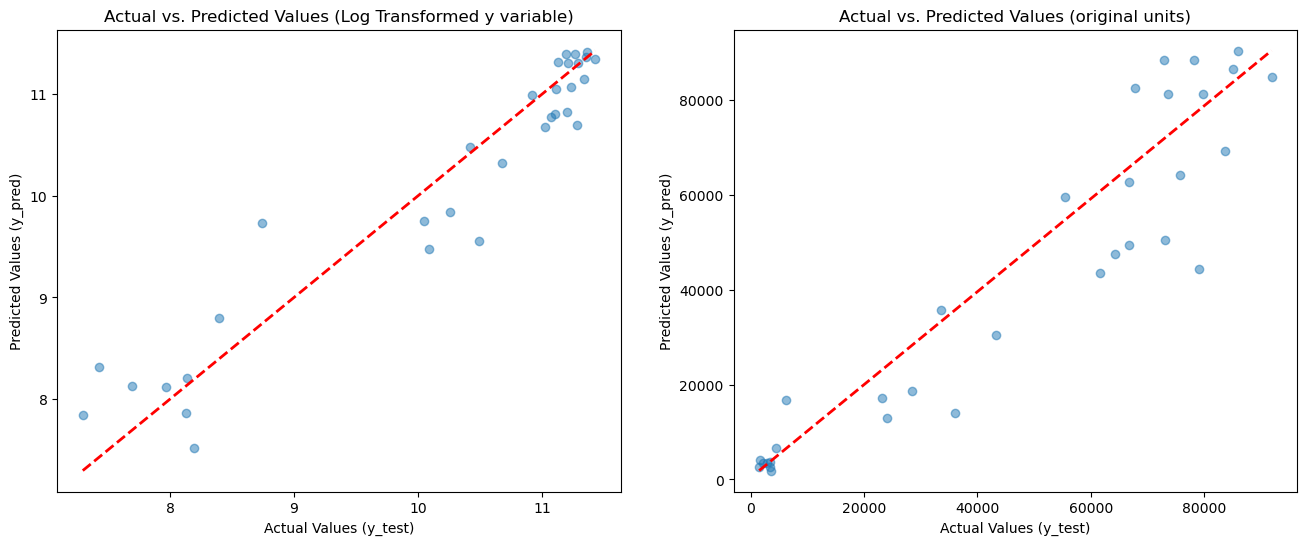

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# first subplot
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].set_xlabel("Actual Values (y_test)")
axes[0].set_ylabel("Predicted Values (y_pred)")
axes[0].set_title("Actual vs. Predicted Values (Log Transformed y variable)")
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)

# second subplot
original_y_pred = np.exp(y_pred)
original_y_test = np.exp(y_test)
axes[1].scatter(original_y_test, original_y_pred, alpha=0.5)
axes[1].set_xlabel("Actual Values (y_test)")
axes[1].set_ylabel("Predicted Values (y_pred)")
axes[1].set_title("Actual vs. Predicted Values (original units)")
axes[1].plot([min(original_y_test), max(original_y_test)], [min(original_y_pred), max(original_y_pred)], color='red', linestyle='--', lw=2)

plt.show()

## Cross Validation implementation to check if the above holds true across the dataset.

In [20]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

results = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    model = sm.OLS(y_train_fold, X_train_fold).fit()

    y_pred = model.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)
    results.append(r2)

average_r2 = np.mean(results)

print("Cross-Validation Results:")
print("Average R2 Score:", average_r2)

Cross-Validation Results:
Average R2 Score: 0.8903554999858196


**Upon Further inspection of the model summary and testing out different combinations of input variables, I found that,**
 - heat_deg_days_c alone explains about 87% variance in our log transformed dependent variable
 - Three other variables ('spd_of_max_gust_kmPerhr', 'day_Saturday', 'day_Sunday') each explain about one percent of variance.
 - I am firm believer of Occam's Razor principle and the curse of dimensionality, and I also believe that there is a tradeoff between explanatory power and simplicity and according to these statements, heat_deg_days_c can be retained while others can be discarded.

### Reasoning behind fitting a Linear Regression model and not Deep Learning methods:
- My limited knowledge in Neural Nets. (going in-depth into ML as I type this and planning to dive deep into ANN's in the near future).
- I always go with the **simplest model** if it does the job as good.
- I also believe that there is a **tradeoff between utility and interpretability**. Opting to implement Linear regression and seeing high R2 values, coefficient values, etc helps us to interpret the model better than advanced black box approaches.